In [665]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.tree import export_text
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import RandomOverSampler
import os
import pickle
from tld import get_tld
from xgboost import XGBRFClassifier

In [245]:
%load_ext autoreload
%autoreload 1

import sys
sys.path.append('../src')

from data import make_dataset
from models import evaluation

%aimport data.make_dataset
%aimport models.evaluation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [246]:
from pymongo import MongoClient, ASCENDING
import numpy as np

MONGO_PASSWORD = os.environ['MONGO_USER_PASSWORD']
CROWD_TANGLE = os.environ['CROWD_TANGLE_API_TOKEN']

config = {
  'host': '18.216.52.13:27017',
  'username': 'mongo_user',
  'password': MONGO_PASSWORD,
  'authSource': 'reddit_climate_news'
}

db = MongoClient(**config).reddit_climate_news

In [375]:
pd.set_option('display.max_rows', 150)

# Load Data

In [2]:
model_df = pd.read_csv('../data/processed/baseline_model_data.csv')

# Clean Data

In [594]:
model_data = model_df[model_df.num_comments > 1]

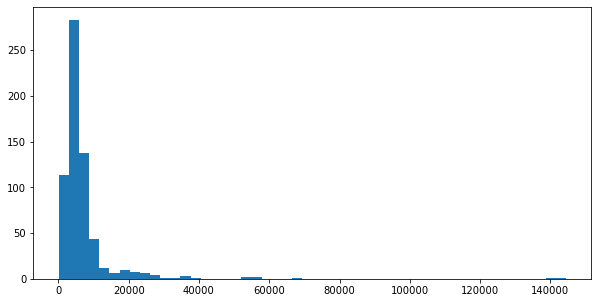

In [598]:
plt.figure(figsize=(10, 5))
plt.hist(model_data.article_length, bins=50);

In [610]:
model_data = model_data[model_data.article_length < 30000]

# EDA - Posting Time

In [22]:
np.sum(model_data[model_data.viral > 0].loc[:, 'hour_bucket_0':'day_of_week_6'])

hour_bucket_0     8
hour_bucket_1     6
hour_bucket_2    20
hour_bucket_3     9
hour_bucket_4    10
hour_bucket_5    10
day_of_week_0    13
day_of_week_1    11
day_of_week_2     8
day_of_week_3    12
day_of_week_4     6
day_of_week_5     5
day_of_week_6     8
dtype: int64

# Classifiers

In [606]:
def print_results(cv_res, scoring):
    for s in scoring:
        print('test_' + s, np.mean(cv_res['test_' + s]))
        print('train_' + s, np.mean(cv_res['train_' + s]))

## Random Forest

In [593]:
model_data.to_csv('../data/processed/prod_training_data.csv')

In [614]:
X_rf, y_rf = model_data[[
#     'commentCount',
#     'num_sub_30',
    'sentiment_score',
    'tag_United States',
    'analytical',
    'tentative',
#     'article_length',
]], model_data.viral
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42, stratify=model_data.viral)

In [603]:
rf_scoring = ['roc_auc', 'recall', 'precision', 'accuracy']

for md in range(5, 15):
    for msl in range(5,21):
        cv_res = evaluation.cross_validate(
            estimator=RandomForestClassifier,
            X=X_train_rf,
            y=y_train_rf,
            scoring=rf_scoring,
            fit_params={
                'max_depth': md,
                'n_estimators': 200,
                'random_state': 42,
                'min_samples_leaf': msl
            },
            oversample=True,
            cv=5
        #         show_conf_matrices=True
        )
        print('********', md, msl, '********')
        print_results(cv_res, rf_scoring)

******** 5 5 ********
roc_auc 0.5969425717852685
recall 0.38
precision 0.14448013903659065
accuracy 0.7181414141414141
******** 5 6 ********
roc_auc 0.5969475655430712
recall 0.38
precision 0.13982142857142857
accuracy 0.7080606060606061
******** 5 7 ********
roc_auc 0.6074444444444445
recall 0.4
precision 0.140225468975469
accuracy 0.7040808080808081
******** 5 8 ********
roc_auc 0.611107365792759
recall 0.42000000000000004
precision 0.13861642743221692
accuracy 0.694040404040404
******** 5 9 ********
roc_auc 0.6104756554307116
recall 0.42000000000000004
precision 0.1374422832627167
accuracy 0.692040404040404
******** 5 10 ********
roc_auc 0.6137915106117353
recall 0.42000000000000004
precision 0.13542088473034763
accuracy 0.688040404040404
******** 5 11 ********
roc_auc 0.6172858926342072
recall 0.43999999999999995
precision 0.14012676708328883
accuracy 0.690040404040404
******** 5 12 ********
roc_auc 0.618302122347066
recall 0.43999999999999995
precision 0.13917702195397713
accuracy

******** 9 5 ********
roc_auc 0.6210811485642945
recall 0.4
precision 0.1816245791245791
accuracy 0.7645656565656566
******** 9 6 ********
roc_auc 0.6220649188514357
recall 0.4
precision 0.19400560224089636
accuracy 0.7825656565656566
******** 9 7 ********
roc_auc 0.6199051186017478
recall 0.38
precision 0.17003907203907204
accuracy 0.7584242424242424
******** 9 8 ********
roc_auc 0.6250674157303371
recall 0.4
precision 0.16074165485930192
accuracy 0.7463232323232324
******** 9 9 ********
roc_auc 0.6216629213483146
recall 0.33999999999999997
precision 0.1421502474134053
accuracy 0.7362424242424244
******** 9 10 ********
roc_auc 0.6116803995006241
recall 0.38
precision 0.14788243075007781
accuracy 0.7342626262626263
******** 9 11 ********
roc_auc 0.6240873907615481
recall 0.44000000000000006
precision 0.1604819636884854
accuracy 0.7262222222222222
******** 9 12 ********
roc_auc 0.6155006242197254
recall 0.44000000000000006
precision 0.15676369607404092
accuracy 0.7202222222222223
******

******** 12 20 ********
roc_auc 0.616171036204744
recall 0.45999999999999996
precision 0.14368905829352077
accuracy 0.679979797979798
******** 13 5 ********
roc_auc 0.6201098626716604
recall 0.31999999999999995
precision 0.17333333333333334
accuracy 0.7786060606060607
******** 13 6 ********
roc_auc 0.6172634207240949
recall 0.31999999999999995
precision 0.1525925925925926
accuracy 0.7584848484848485
******** 13 7 ********
roc_auc 0.6189038701622971
recall 0.36
precision 0.14604700854700853
accuracy 0.7302828282828283
******** 13 8 ********
roc_auc 0.6266916354556804
recall 0.38
precision 0.15368778280542986
accuracy 0.7443030303030304
******** 13 9 ********
roc_auc 0.6249687890137329
recall 0.33999999999999997
precision 0.14273504273504273
accuracy 0.7382626262626264
******** 13 10 ********
roc_auc 0.6167815230961299
recall 0.36
precision 0.14190768118661856
accuracy 0.7342828282828284
******** 13 11 ********
roc_auc 0.6262721598002496
recall 0.39999999999999997
precision 0.14732142857

In [ ]:
# with comment count
******** 2 17 ********
roc_auc 0.6875727136431784
recall 0.6000000000000001
precision 0.12389051941846971
accuracy 0.6352126984126985

# without
******** 2 17 ********
roc_auc 0.6174587706146927
recall 0.62
precision 0.13737915984724497
accuracy 0.6592888888888888

In [198]:
sorted(zip(X_train_rf.columns, cv_res['estimators'][0].feature_importances_), key=lambda x: -x[1])

[('sentiment_score', 0.47554290409749256),
 ('tag_United States', 0.34055033014128244),
 ('tentative', 0.14038993404561373),
 ('analytical', 0.04351683171561142)]

In [ ]:
# first pass
roc_auc 0.6039565217391304
recall 0.06000000000000001
precision 0.13333333333333333
accuracy 0.8948571428571428

# with article length
roc_auc 0.6033583208395802
recall 0.04
precision 0.16666666666666666
accuracy 0.9092317460317461

# and tentative and analytical
roc_auc 0.6154362818590704
recall 0.04
precision 0.26666666666666666
accuracy 0.9060190476190476

----- without timing -------

# just fb comments, sentiment, posts in last 30
roc_auc 0.5570367316341829
recall 0.12
precision 0.1595238095238095
accuracy 0.874120634920635

# add United States tag
roc_auc 0.6133928035982009
recall 0.18000000000000002
precision 0.2411111111111111
accuracy 0.8868825396825397

# add tentative and analytical
roc_auc 0.6207976011994003
recall 0.16
precision 0.24238095238095236
accuracy 0.8868571428571428

# add article length
roc_auc 0.6250314842578711
recall 0.16
precision 0.305
accuracy 0.9044444444444444

In [625]:
# Best Params

rf_params = {
    'max_depth': 5,
    'n_estimators': 300,
    'random_state': 42,
    'min_samples_leaf': 200
}

test_roc_auc 0.5951548064918851
train_roc_auc 0.6173967294573034
test_recall 0.56
train_recall 0.5844404801026556
test_precision 0.13565066363906683
train_precision 0.5983684972951607
test_accuracy 0.5974141414141415
train_accuracy 0.5956418321518553


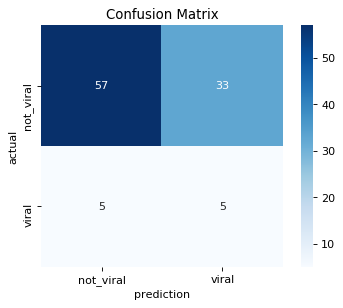

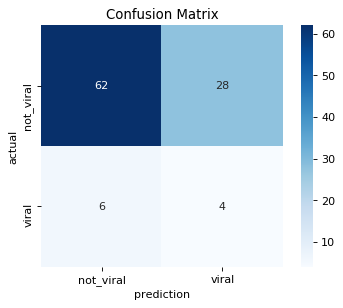

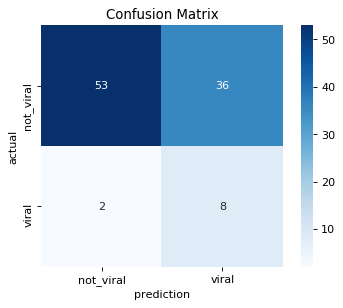

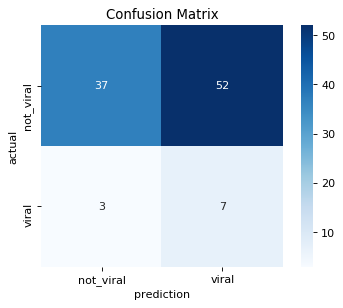

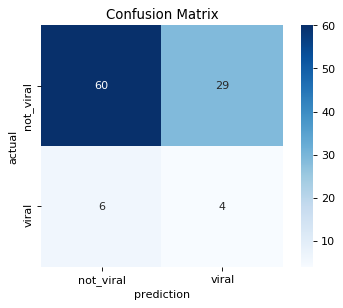

In [626]:
cv_res = evaluation.cross_validate(
    estimator=RandomForestClassifier,
    X=X_train_rf,
    y=y_train_rf,
    scoring=rf_scoring,
    fit_params=rf_params,
    oversample=True,
    cv=5,
    show_conf_matrices=True,
    threshold=.5,
)
print_results(cv_res, rf_scoring)

**Take Aways**

Text Razor and Crowd Tangle didn't add that much explanatory power
Should be able to easily use vader and (maybe) IBM to run it on every post in r/WorldNews

Maybe even just sentiment and the United States tag is enough to make decent predictions

In [572]:
sorted(zip(X_train_rf.columns, cv_res['estimators'][0].feature_importances_), key=lambda x: -x[1])

[('sentiment_score', 0.47554290409749256),
 ('tag_United States', 0.34055033014128244),
 ('tentative', 0.14038993404561373),
 ('analytical', 0.04351683171561142)]

### Final Model

In [648]:
ros = RandomOverSampler(random_state=42)
X_fin_ros, y_fin_ros = ros.fit_resample(X_train_rf, y_train_rf)

rf_final = RandomForestClassifier(**rf_params)
rf_final.fit(X_fin_ros, y_fin_ros)
preds_final = rf_final.predict(X_test_rf)
pred_proba_final = rf_final.predict_proba(X_test_rf)

print('roc', roc_auc_score(y_true=y_test_rf, y_score=pred_proba_final[:, 1]))
print('prec', precision_score(y_true=y_test_rf, y_pred=preds_final))
print('rec', recall_score(y_true=y_test_rf, y_pred=preds_final))
print('random', y_test_rf[y_test_rf > 0].shape[0] / y_test_rf.shape[0])

roc 0.45707417582417587
prec 0.05128205128205128
rec 0.15384615384615385
random 0.104


## Larger Dataset

In [533]:
posts_raw = pd.DataFrame.from_records(
    db.submissions.find({},
                        {'sentiment_score': 1, 'url': 1, 'num_comments': 1, 'tone_analyzer': 1})
)

In [544]:
def extract_score(raw, tone_id):
    scores = [x['score'] for x in raw['document_tone']['tones'] if x['tone_id'] == tone_id]
    return scores[0] if scores else np.nan

In [655]:
all_posts = posts_raw[~posts_raw.tone_analyzer.isnull()]
# pull out analytical and tentative
all_posts['analytical'] = all_posts.tone_analyzer.map(lambda ta: extract_score(ta, 'analytical'))
all_posts['tentative'] = all_posts.tone_analyzer.map(lambda ta: extract_score(ta, 'tentative'))
all_posts = all_posts.fillna(0)

/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [267]:
with open('../data/raw/media_cloud_all_sources.pickle', 'rb') as read_file:
    media_sources = pickle.load(read_file)

In [656]:
unique_media = media_sources[['tld', 'media_source_tags']].drop_duplicates(subset='tld')
unique_media['us_media_source'] = unique_media.media_source_tags.map(lambda ts: 'United States' in [x['label'] for x in ts])

In [279]:
def extract_tld(u):
    try:
        return get_tld(u, as_object=True).domain
    except:
        print(u)
        return np.nan

In [657]:
all_posts['tld'] = all_posts.url.map(extract_tld)
all_posts = all_posts[~all_posts.tld.isnull()]
all_posts = all_posts.sort_values('num_comments', ascending=False).drop_duplicates(subset=['url'])

merged_df = all_posts.merge(unique_media[['tld', 'us_media_source']], how='left', on='tld')


http://https//www.baltimoresun.com/coronavirus/bs-hs-coronavirus-wrap-up-20200306-ipbh7t5r4zhxpidx3kgeiq3seu-story.html%3foutputType=amp
http://Hc
/user/atechsmart/comments/f5yiks/preventcoronavirus/
http://it-mining-waste-dumping-in-waterways/2017/0https://www.washingtonpost.com/videonational/president-trump-signs-resolution-to-perm2/21/cde426aa-f84b-11e6-aa1e-5f735ee31334_video.html
http://[Imgur](https://i.imgur.com/wdqzhvo.jpg)
http://www.google.comhsywhw
http://Httpsuckmyass
/r/moneyontheside/comments/et8tmz/earn_money_for_free/
http://Fatasianguy
http://contraponto-a-teoria-da-evolucao.shtml
http://[MarketWatch](https://www.marketwatch.com/story/british-lawmakers-give-final-approval-for-boris-johnsons-brexit-deal-2020-01-09)
https://https://edition.cnn.com/middleeast/live-news/us-iran-news-01-08-2020/h_afb39d945a5ac07cfadb725e260d3d81.cnn.com/middleeast/live-news/us-iran-news-01-08-2020/index.html
http://Butt
http://https//kiokomedia.site/﻿
http://Sksksksk
http://Viwe
http://217.

In [658]:
merged_df['viral'] = merged_df.num_comments.map(lambda x: 1 if x > 300 else 0)
merged_df['us_media_source'] = merged_df.us_media_source.fillna(False)

In [659]:
merged_df = merged_df[merged_df.num_comments > 1]

In [660]:
X_all, y_all = merged_df[[
#     'commentCount',
#     'num_sub_30',
    'sentiment_score',
    'us_media_source',
    'analytical',
    'tentative',
#     'article_length',
]], merged_df.viral
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=merged_df.viral)

In [652]:
for md in [4, 5, 6, 7]:
    for msl in [15, 20, 30, 40]:
        cv_res = evaluation.cross_validate(
            estimator=RandomForestClassifier,
            X=X_train_all,
            y=y_train_all,
            scoring=rf_scoring,
            fit_params={
                'max_depth': md,
                'n_estimators': 200,
                'random_state': 42,
                'min_samples_leaf': msl
            },
            oversample=True,
            cv=5
        #         show_conf_matrices=True
        )
        print('********', md, msl, '********')
        print_results(cv_res, rf_scoring)

******** 4 15 ********
test_roc_auc 0.592338932530563
train_roc_auc 0.627193845189236
test_recall 0.6763975155279504
train_recall 0.7129005388860676
test_precision 0.046660939282790095
train_precision 0.5668926688449765
test_accuracy 0.46248071864603124
train_accuracy 0.5841269146873367
******** 4 20 ********
test_roc_auc 0.592632320468776
train_roc_auc 0.6270101080125389
test_recall 0.6795031055900621
train_recall 0.7147720973638776
test_precision 0.04675406930038507
train_precision 0.5667096394262069
test_accuracy 0.46127661051239893
train_accuracy 0.5841575909447322
******** 4 30 ********
test_roc_auc 0.592592945244353
train_roc_auc 0.6265283876214655
test_recall 0.6770186335403727
train_recall 0.7117407994822039
test_precision 0.046710992700694356
train_precision 0.5664220519440327
test_accuracy 0.46259877682549694
train_accuracy 0.5834795435699727
******** 4 40 ********
test_roc_auc 0.5924465925306744
train_roc_auc 0.626078508037283
test_recall 0.6745341614906832
train_recall 0.70

test_roc_auc 0.592250107249894
train_roc_auc 0.6293184368894346
test_recall 0.6774902647975077
train_recall 0.7186520240176428
test_precision 0.04999371348044985
train_precision 0.566391937632577
test_accuracy 0.45735575712096727
train_accuracy 0.5841812717964128


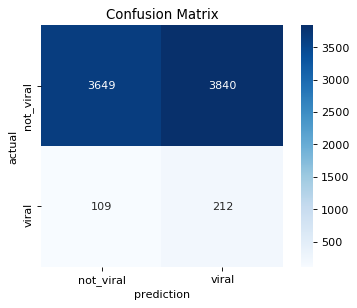

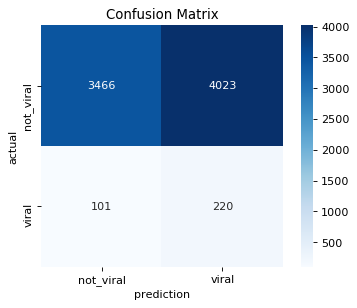

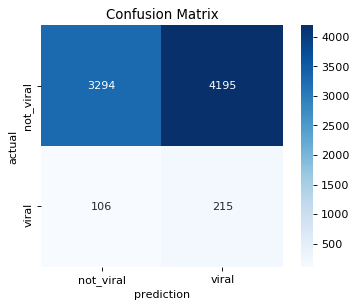

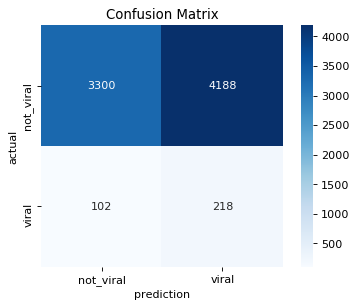

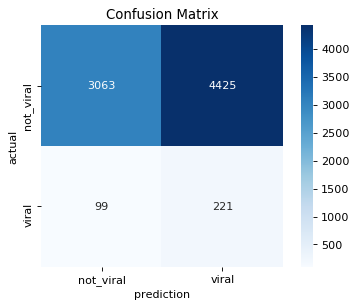

In [669]:
cv_res = evaluation.cross_validate(
    estimator=RandomForestClassifier,
    X=X_train_all,
    y=y_train_all,
    scoring=rf_scoring,
    fit_params={
        'n_estimators': 300,
        'max_depth': 4,
        'min_samples_leaf': 20,
        'random_state': 42
    },
    oversample=True,
    cv=5,
    show_conf_matrices=True,
    threshold=.5
)
print_results(cv_res, rf_scoring)

In [ ]:
# precision recall curve

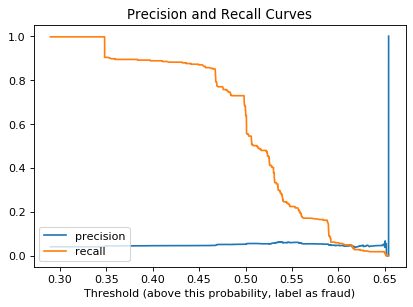

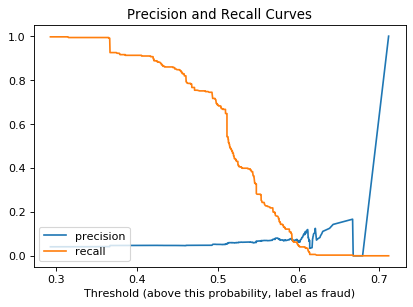

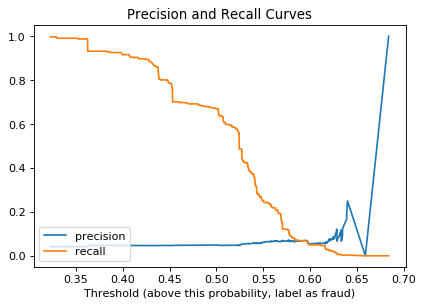

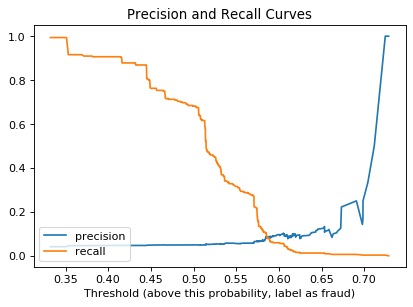

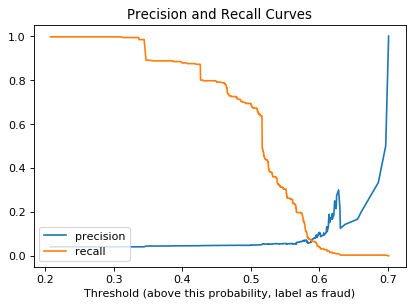

In [667]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

for i in range(len(cv_res['y_true'])):
    y_true = cv_res['y_true'][i]
    y_preds_proba = cv_res['y_proba_preds'][i]

    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_true, y_preds_proba[:, 1])

    plt.figure(dpi=80)
    plt.plot(threshold_curve, precision_curve[1:],label='precision')
    plt.plot(threshold_curve, recall_curve[1:], label='recall')
    plt.legend(loc='lower left')
    plt.xlabel('Threshold (above this probability, label as fraud)');
    plt.title('Precision and Recall Curves');

### Final Model

In [662]:
ros = RandomOverSampler(random_state=42)
X_fin_ros, y_fin_ros = ros.fit_resample(X_train_all, y_train_all)

rf_final = RandomForestClassifier(**{
        'n_estimators': 300,
        'max_depth': 4,
        'min_samples_leaf': 20,
        'random_state': 42
    })
rf_final.fit(X_fin_ros, y_fin_ros)
preds_final = rf_final.predict(X_test_all)
pred_proba_final = rf_final.predict_proba(X_test_all)

print('roc', roc_auc_score(y_true=y_test_all, y_score=pred_proba_final[:, 1]))
print('prec', precision_score(y_true=y_test_all, y_pred=preds_final))
print('rec', recall_score(y_true=y_test_all, y_pred=preds_final))
print('random', y_test_all[y_test_all > 0].shape[0] / y_test_all.shape[0])

roc 0.6059345547039355
prec 0.050098056694597964
rec 0.7007481296758105
random 0.04107764802294612


In [678]:
for thresh in [.1 + x*0.05 for x in range(18)]:
    p = [1 if x > thresh else 0 for x in pred_proba_final[:, 1]]
    print(thresh, '-', precision_score(y_true=y_test_all, y_pred=p), f'{np.sum(p) / len(p)}%')

0.1 - 0.04107764802294612 1.0%
0.15000000000000002 - 0.04107764802294612 1.0%
0.2 - 0.04107764802294612 1.0%
0.25 - 0.04107764802294612 1.0%
0.30000000000000004 - 0.041086065573770494 0.9997951239500102%
0.35 - 0.04124246831498026 0.9860684286006965%
0.4 - 0.04646672673445746 0.795841016185208%
0.45000000000000007 - 0.04717237629146275 0.7535341118623233%
0.5 - 0.050098056694597964 0.5745748821962713%
0.55 - 0.06671159029649595 0.1520180290923991%
0.6 - 0.08771929824561403 0.023355869698832205%
0.65 - 0.09090909090909091 0.0011268182749436591%
0.7000000000000001 - 0.0 0.0%
0.75 - 0.0 0.0%
0.8 - 0.0 0.0%
0.85 - 0.0 0.0%
0.9 - 0.0 0.0%
0.9500000000000001 - 0.0 0.0%


In [ ]:
# if I take 20 samples, and I take the top 3, what precision am I likely to get

In [697]:
posted = []
for _ in range(100000):
    articles_probs = np.random.choice([0, 5, 6.7, 8.8, 9.1], 20, p=[0.426, .422, 0.129, 0.022, 0.001])
    presented = sorted([x for x in articles_probs if x > 0], key=lambda x: -x)[:3]
    picked = np.random.choice(presented, 1)
    posted.append(picked)
np.mean(posted)

6.679226999999999

In [699]:
merged_df[merged_df.viral == 1].num_comments.mean()

1646.370259481038

In [700]:
merged_df[merged_df.viral == 0].num_comments.mean()

18.75158106144774

In [702]:
no_model_prec = 0.041
model_prec = 0.067
num_posts = 3 * 52
no_model = 19*num_posts*(1-no_model_prec) + 1646*num_posts*no_model_prec
with_model = 19*num_posts*(1-model_prec) + 1646*num_posts*model_prec

In [703]:
no_model

13370.292000000001

In [704]:
with_model

19969.404000000002

In [705]:
with_model / no_model

1.4935652863826758

# Isolation Forest

## Big Data Set

In [636]:
if_params = {
    'n_estimators': 200,
    'random_state': 42,
    'contamination': 0.007
}

In [637]:
iso_f = IsolationForest(**if_params)
X_iso_tr, X_iso_val, y_iso_tr, y_iso_val = train_test_split(
    X_train_all, y_train_all, test_size=0.2, random_state=42)
iso_f.fit(X_iso_tr, y_iso_tr)
iso_preds = iso_f.predict(X_iso_val)

/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [638]:
iso_res = pd.DataFrame(zip(iso_preds, y_iso_val), columns=['preds', 'actual'])


In [639]:
iso_res[iso_res.preds == -1]

,preds,actual
5,-1,0
37,-1,0
650,-1,0
776,-1,0
806,-1,0
853,-1,0
869,-1,0
1003,-1,0
1088,-1,0
1108,-1,0


In [ ]:
# Only one of the anomalies has over 1000 comments

## Smaller Dataset

In [381]:
if_params = {
    'n_estimators': 200,
    'random_state': 42,
    'contamination': 0.08
}

iso_f = IsolationForest(**if_params)
X_iso_tr, X_iso_val, y_iso_tr, y_iso_val = train_test_split(
    X_train_rf, y_train_rf, test_size=0.2, random_state=42)
iso_f.fit(X_iso_tr, y_iso_tr)
iso_preds = iso_f.predict(X_iso_val)

/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [383]:
iso_res = pd.DataFrame(zip(iso_preds, y_iso_val), columns=['preds', 'actual'])

In [384]:
iso_res.corr()

,preds,actual
preds,1.000000,0.100343
actual,0.100343,1.000000


In [385]:
iso_res[iso_res.preds == -1]

,preds,actual
11,-1,0
22,-1,0
37,-1,0
53,-1,0
55,-1,0
80,-1,0
97,-1,0
98,-1,0
115,-1,0
118,-1,0


In [387]:
y_iso_val.value_counts()

0    115
1     11
Name: viral, dtype: int64

# Dimensionality Reduction

In [395]:
X_dr, y_dr = model_data.drop(columns=[
    'Unnamed: 0',
    '_id',
    'created_utc',
    'num_comments',
    'score',
    'url',
#     'sentiment_score',
    'text',
    'tones',
    'fb_interactions',
#     'num_images',
    'viral',
#     'comm_per_post_30',
    'interactions',
    'log_comments',
    'post_date'
]), model_data.viral
X_train_dr, X_test_dr, y_train_dr, y_test_dr = train_test_split(
    X_dr, y_dr, test_size=0.2, random_state=42, stratify=model_data.viral)

In [396]:
X_dr_tr, X_dr_val, y_dr_tr, y_dr_val = train_test_split(
    X_train_dr, y_train_dr, test_size=0.2, random_state=42, stratify=y_train_dr)

In [458]:
categoricals = [
    'hour_bucket_0',
    'hour_bucket_1',
    'hour_bucket_2',
    'hour_bucket_3',
    'hour_bucket_4',
    'hour_bucket_5',
    'day_of_week_0',
    'day_of_week_1',
    'day_of_week_2',
    'day_of_week_3',
    'day_of_week_4',
    'day_of_week_5',
    'day_of_week_6',
    'tag_technorati_uspolitics_20100709',
    'tag_none',
    'tag_print_native',
    'tag_national',
    'tag_geo_USA',
    'tag_en',
    'tag_United States',
]

In [495]:
def scale_and_reduce_fit_transform(df):
    std = StandardScaler()
    X_dr_std = pd.DataFrame(std.fit_transform(df.drop(columns=categoricals)))
    X_dr_std = pd.concat([X_dr_std, df[categoricals].reset_index()], axis=1).drop(columns=['index'])
    pca = PCA(n_components=10)
    X_dr_pca = pca.fit_transform(X_dr_std)
    print(np.sum(pca.explained_variance_ratio_))
    
    def apply_tranform(df2):
        data_std = pd.DataFrame(std.transform(df2.drop(columns=categoricals)))
        data_std = pd.concat([data_std, df2[categoricals].reset_index()], axis=1).drop(columns=['index'])
        data_std = pca.transform(data_std)
        return data_std

    return X_dr_pca, apply_tranform

In [496]:
X_dr_pca, apply_transform = scale_and_reduce_fit_transform(X_dr_tr)

0.5491996806187708


In [497]:
ros = RandomOverSampler(random_state=42)
X_dr_ros, y_dr_ros = ros.fit_resample(X_dr_pca, y_dr_tr)

In [498]:
for md in [2, 5, 10, 15]:
    for ms in [5, 7, 15, 20]:
        rf_pca = RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            max_depth=md,
            min_samples_leaf=ms
        )
        rf_pca.fit(X_dr_ros, y_dr_ros)
        val_tr = apply_transform(X_dr_val)
        preds_pca = rf_pca.predict(val_tr)

        print('*******', md, ms, '*******')
        print('acc', accuracy_score(y_dr_val, preds_pca))
        print('prec', precision_score(y_dr_val, preds_pca))
        print('recall', recall_score(y_dr_val, preds_pca))
        print('roc', roc_auc_score(y_dr_val, preds_pca))

******* 2 5 *******
acc 0.6825396825396826
prec 0.058823529411764705
recall 0.2
roc 0.46206896551724136
******* 2 7 *******
acc 0.6904761904761905
prec 0.06060606060606061
recall 0.2
roc 0.4663793103448276
******* 2 15 *******
acc 0.6666666666666666
prec 0.05555555555555555
recall 0.2
roc 0.45344827586206893
******* 2 20 *******
acc 0.6666666666666666
prec 0.05555555555555555
recall 0.2
roc 0.45344827586206893
******* 5 5 *******
acc 0.7857142857142857
prec 0.09523809523809523
recall 0.2
roc 0.5181034482758621
******* 5 7 *******
acc 0.7936507936507936
prec 0.1
recall 0.2
roc 0.5224137931034483
******* 5 15 *******
acc 0.7777777777777778
prec 0.09090909090909091
recall 0.2
roc 0.5137931034482759
******* 5 20 *******
acc 0.7301587301587301
prec 0.07142857142857142
recall 0.2
roc 0.4879310344827586
******* 10 5 *******
acc 0.8968253968253969
prec 0.0
recall 0.0
roc 0.4870689655172414
******* 10 7 *******
acc 0.8650793650793651
prec 0.0
recall 0.0
roc 0.4698275862068966
******* 10 15 ****

# XG Boost

In [508]:
xg_scoring = ['roc_auc', 'recall', 'precision', 'accuracy']

for md in [2, 3, 10, 15, 20]:
    for g in [10**x for x in range(4)]:
        cv_res = evaluation.cross_validate(
            estimator=XGBRFClassifier,
            X=X_train_rf,
            y=y_train_rf,
            scoring=xg_scoring,
            fit_params={
                'max_depth': md,
                'n_estimators': 200,
                'random_state': 42,
                'gamma': g
            },
            oversample=True,
            cv=5
        #         show_conf_matrices=True
        )
        print('*****', md, g, '******')
        print_results(cv_res, xg_scoring)

***** 2 1 ******
roc_auc 0.5902856071964019
recall 0.54
precision 0.11835266248110685
accuracy 0.6241015873015873
***** 2 10 ******
roc_auc 0.5909722638680661
recall 0.5599999999999999
precision 0.1237509708996749
accuracy 0.6272761904761904


/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


***** 2 100 ******
roc_auc 0.5
recall 0.6
precision 0.047619047619047616
accuracy 0.4156190476190476


/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


***** 2 1000 ******
roc_auc 0.5
recall 0.6
precision 0.047619047619047616
accuracy 0.4156190476190476
***** 3 1 ******
roc_auc 0.5554880059970014
recall 0.41999999999999993
precision 0.11396035655641565
accuracy 0.6861841269841269
***** 3 10 ******
roc_auc 0.5610839580209894
recall 0.41999999999999993
precision 0.10774271334550081
accuracy 0.6734730158730159


/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


***** 3 100 ******
roc_auc 0.5
recall 0.6
precision 0.047619047619047616
accuracy 0.4156190476190476


/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


***** 3 1000 ******
roc_auc 0.5
recall 0.6
precision 0.047619047619047616
accuracy 0.4156190476190476
***** 10 1 ******
roc_auc 0.5510659670164918
recall 0.13999999999999999
precision 0.11883541295306002
accuracy 0.8454857142857142
***** 10 10 ******
roc_auc 0.5424527736131933
recall 0.2
precision 0.12043650793650792
accuracy 0.8168507936507936


/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


***** 10 100 ******
roc_auc 0.5
recall 0.6
precision 0.047619047619047616
accuracy 0.4156190476190476


/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


***** 10 1000 ******
roc_auc 0.5
recall 0.6
precision 0.047619047619047616
accuracy 0.4156190476190476
***** 15 1 ******
roc_auc 0.5498515742128935
recall 0.13999999999999999
precision 0.11818181818181817
accuracy 0.8470984126984126
***** 15 10 ******
roc_auc 0.5433148425787107
recall 0.2
precision 0.12733893557422968
accuracy 0.8232126984126984


/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


***** 15 100 ******
roc_auc 0.5
recall 0.6
precision 0.047619047619047616
accuracy 0.4156190476190476


/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


***** 15 1000 ******
roc_auc 0.5
recall 0.6
precision 0.047619047619047616
accuracy 0.4156190476190476
***** 20 1 ******
roc_auc 0.5498515742128935
recall 0.13999999999999999
precision 0.11818181818181817
accuracy 0.8470984126984126
***** 20 10 ******
roc_auc 0.5433148425787107
recall 0.2
precision 0.12733893557422968
accuracy 0.8232126984126984


/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


***** 20 100 ******
roc_auc 0.5
recall 0.6
precision 0.047619047619047616
accuracy 0.4156190476190476


/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


***** 20 1000 ******
roc_auc 0.5
recall 0.6
precision 0.047619047619047616
accuracy 0.4156190476190476


/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# KNN

In [509]:
from sklearn.neighbors import KNeighborsClassifier

In [517]:
cv_res = evaluation.cross_validate(
    estimator=KNeighborsClassifier,
    X=X_train_rf,
    y=y_train_rf,
    scoring=xg_scoring,
    fit_params={'n_neighbors': 3},
    cv=5
#         show_conf_matrices=True
)

print_results(cv_res, xg_scoring)

roc_auc 0.5273883058470764
recall 0.04
precision 0.2
accuracy 0.9076571428571428


In [ ]:
# did it get the big outliers right? or the smaller ones?

In [519]:
cv_res.keys()

dict_keys(['test_recall', 'train_recall', 'test_precision', 'train_precision', 'test_accuracy', 'train_accuracy', 'test_roc_auc', 'train_roc_auc', 'y_proba_preds', 'estimators', 'y_preds', 'y_true', 'X_test'])

In [530]:
pd.concat([
    pd.DataFrame(cv_res['y_preds'][0], columns=['pred_viral', 'pred_no']),
    pd.DataFrame(np.array(cv_res['y_true'][0]).reshape(-1,1), columns=['actual_viral'])
], axis=1)

,pred_viral,pred_no,actual_viral
0,1.000000,0.000000,0
1,1.000000,0.000000,1
2,0.666667,0.333333,0
3,0.666667,0.333333,0
4,1.000000,0.000000,0
5,0.666667,0.333333,0
6,1.000000,0.000000,1
7,1.000000,0.000000,1
8,1.000000,0.000000,0
9,0.666667,0.333333,0
